# Bus Classifier
## External modules needed

In [36]:
# Based on https://www.kaggle.com/l0new0lf/vehicle-classification

import os
import numpy as np
import pandas as pd
# %matplotlib inline
import matplotlib.pyplot as plt
import base64
import random
from pathlib import Path
import shutil
from collections import OrderedDict
import cv2
from PIL import Image

import keras
# For one-hot-encoding
from keras.utils import np_utils
# For creating sequenttial model
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout
# For saving and loading models
from keras.models import load_model

from keras.preprocessing.image import ImageDataGenerator
from keras.applications import ResNet50
from keras.applications.resnet50 import preprocess_input
from keras import Model, layers
from keras.models import load_model, model_from_json

## Dataset handling and exploration

In [51]:
# BASE_PATH = Path('C:/Users/jaherran/Projects/Python/BusClassifier/vehicle/train/train/')
BASE_PATH = Path('/home/jaimehmol/Projects/Python/BusClassifierWorkspace/BusClassifier/data/raw/train/')
# INPUT_WORKING_PATH = Path('C:/Users/jaherran/Projects/Python/BusClassifier/vehicle/working/data/')
INPUT_WORKING_PATH = Path('/home/jaimehmol/Projects/Python/BusClassifierWorkspace/BusClassifier/data/prepared/')
# OUTPUT_MODELS_PATH = Path('C:/Users/jaherran/Projects/Python/BusClassifier/vehicle/working/models/')
OUTPUT_MODELS_PATH = Path('/home/jaimehmol/Projects/Python/BusClassifierWorkspace/BusClassifier/model/')

classes = os.listdir(BASE_PATH)

# create dict of list of images per class
dataset = {}
for vehicle in classes:
    dataset[vehicle] = [i for i in os.listdir(BASE_PATH / vehicle)]

In [52]:
# verify
print(dataset.keys())
print(len(dataset.keys()))

dict_keys(['Motorcycle', 'Car', 'Bicycle', 'Tank', 'Van', 'Boat', 'Bus', 'Caterpillar', 'Snowmobile', 'Cart', 'Taxi', 'Helicopter', 'Segway', 'Ambulance', 'Truck', 'Limousine', 'Barge'])
17


In [53]:
# convert dict to pandas df
df = pd.DataFrame.from_dict(dataset, orient='index')
df = df.transpose()

In [54]:
df.head()

Motorcycle            Car        Bicycle           Tank            Van  \
0  002403_17.jpg  002844_10.jpg  001399_02.jpg  003310_04.jpg  000211_15.jpg   
1  002447_04.jpg  000338_14.jpg  002536_01.jpg  001915_02.jpg  000123_17.jpg   
2  004716_00.jpg  003319_09.jpg  005417_02.jpg  000223_01.jpg  002387_10.jpg   
3  000433_02.jpg  002206_10.jpg  000847_19.jpg  000664_05.jpg  002080_00.jpg   
4  004890_10.jpg  000607_18.jpg  002568_01.jpg  000315_12.jpg  001215_01.jpg   

            Boat            Bus    Caterpillar     Snowmobile           Cart  \
0  000036_06.jpg  000047_01.jpg  002652_18.jpg  002649_10.jpg  000863_03.jpg   
1  004802_02.jpg  000037_03.jpg  002148_02.jpg  000277_10.jpg  000982_18.jpg   
2  002250_03.jpg  003803_00.jpg  000580_18.jpg  001237_05.jpg  003323_18.jpg   
3  000049_10.jpg  002930_17.jpg  001579_18.jpg  003481_18.jpg  005326_05.jpg   
4  000470_10.jpg  000052_16.jpg  004012_18.jpg  000119_11.jpg  003587_18.jpg   

            Taxi     Helicopter         Segway      Ambulance          Truck  \
0  002014_02.jpg  003440_09.jpg  002438_09.jpg  000490_01.jpg  001171_19.jpg   
1  000061_15.jpg  004794_05.jpg  001668_10.jpg  003451_10.jpg  000046_07.jpg   
2  002604_09.jpg  004779_00.jpg  002601_09.jpg  002199_00.jpg  003076_05.jpg   
3  002814_09.jpg  005079_00.jpg  001748_01.jpg  002547_03.jpg  004711_02.jpg   
4  000565_15.jpg  000293_14.jpg  002550_03.jpg  000149_15.jpg  002187_10.jpg   

       Limousine          Barge  
0  003854_00.jpg  000300_08.jpg  
1  004582_10.jpg  000689_15.jpg  
2  004355_10.jpg  002368_05.jpg  
3  003001_01.jpg  000884_10.jpg  
4  003050_02.jpg  002659_00.jpg

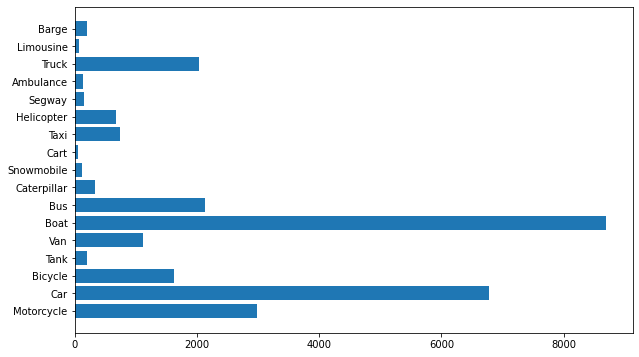

In [55]:
cols = []
col_imgs = []
for col in df.columns:
    cols.append(col)
    col_imgs.append(df[col].count())

plt.figure(figsize=(10,6))
plt.barh(cols, col_imgs)
plt.show()

Displaying 4 ranndom image per vehicle class


<Figure size 432x288 with 0 Axes>

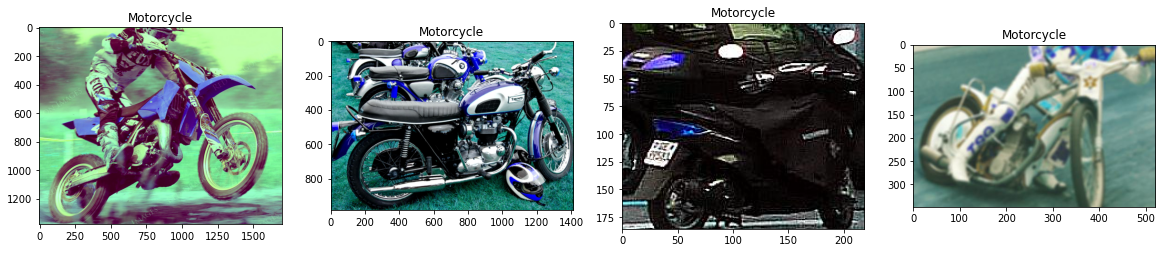

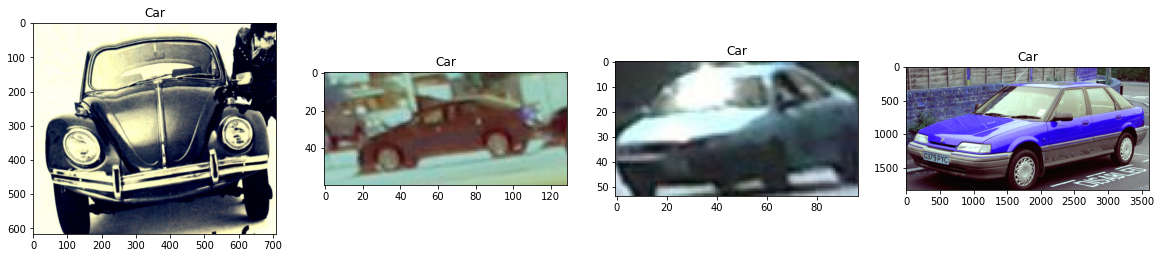

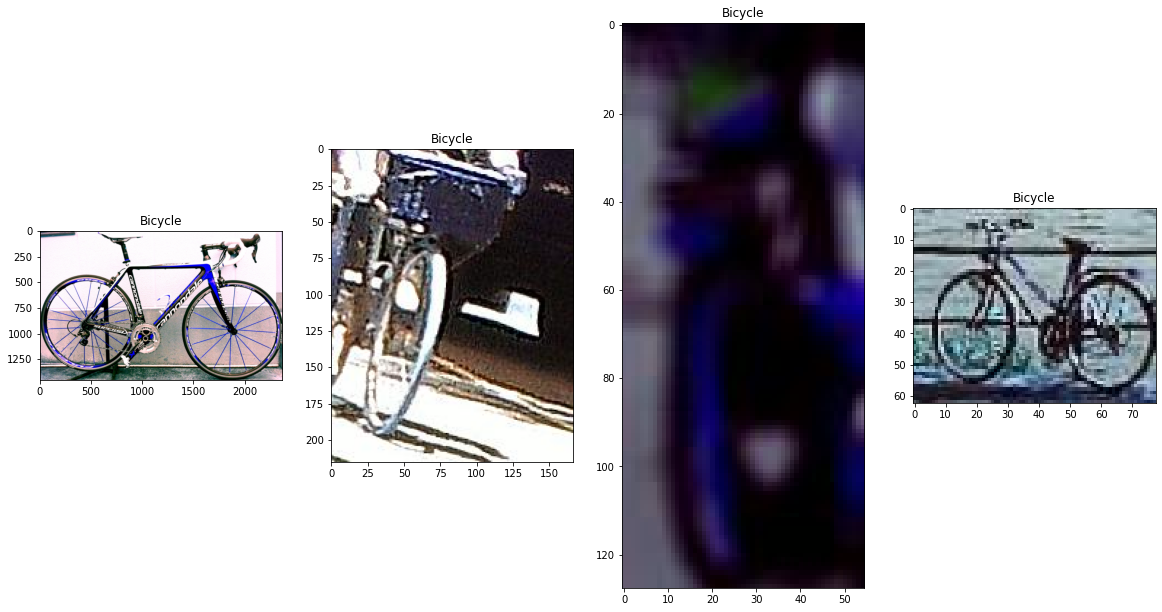

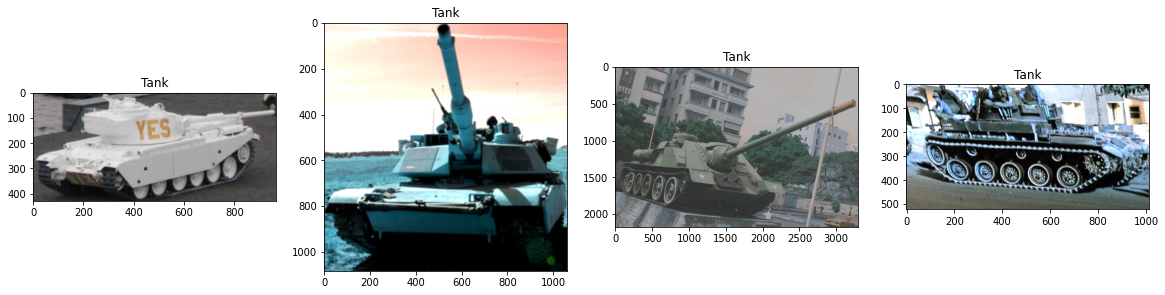

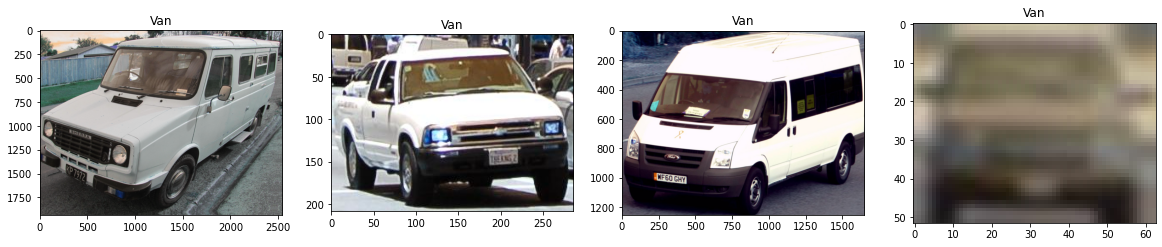

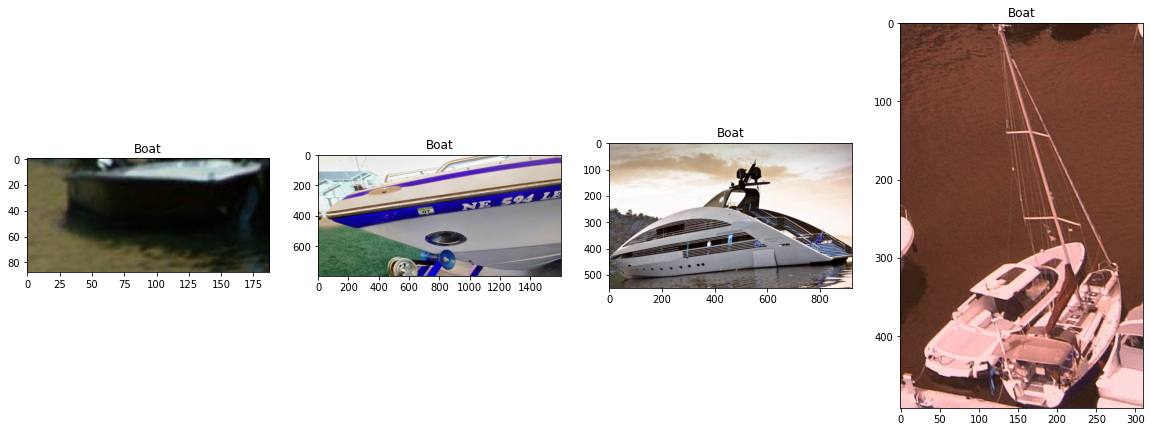

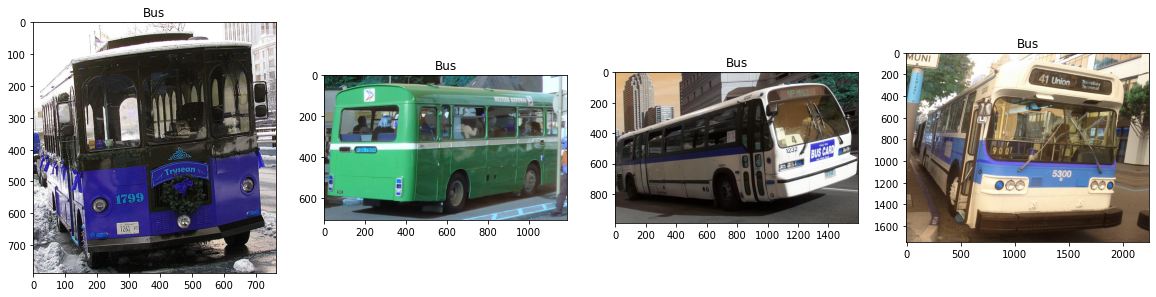

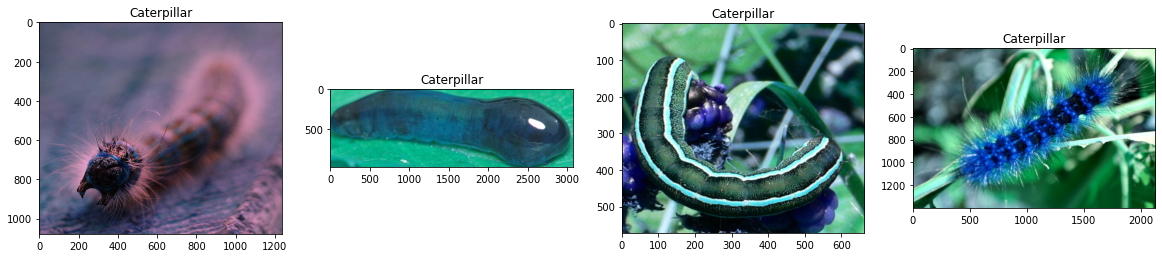

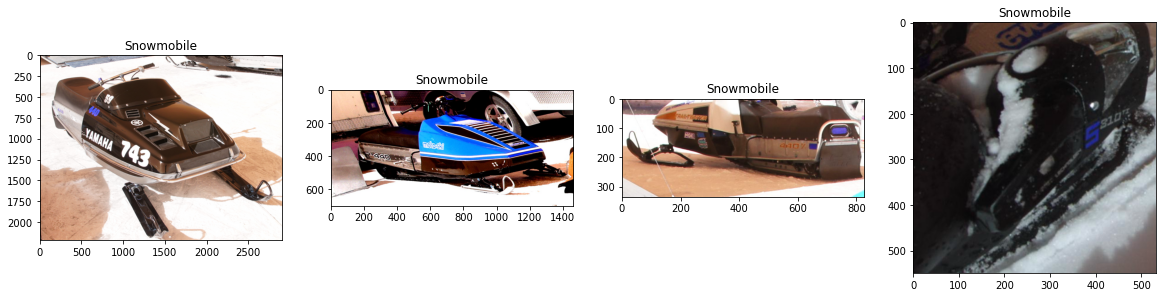

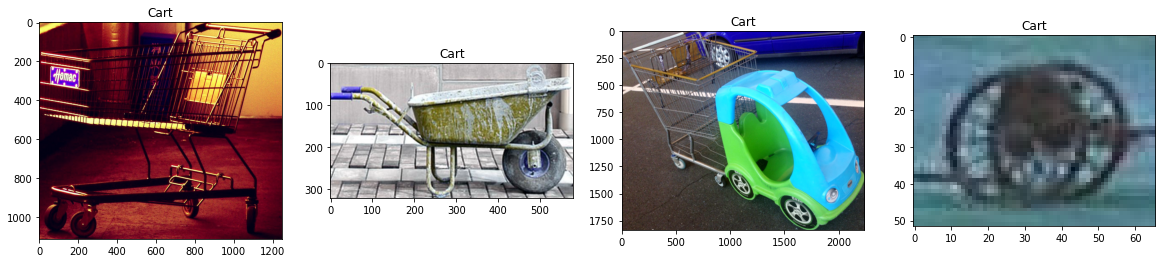

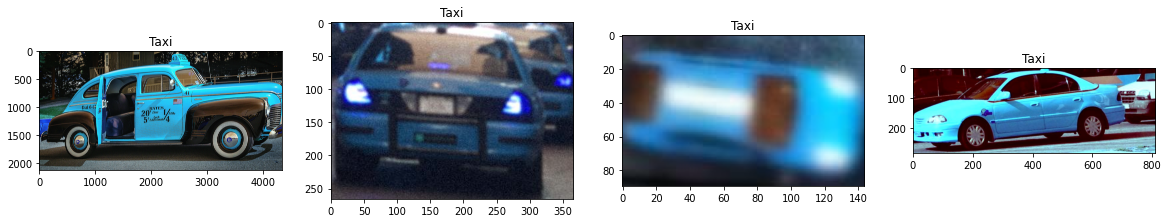

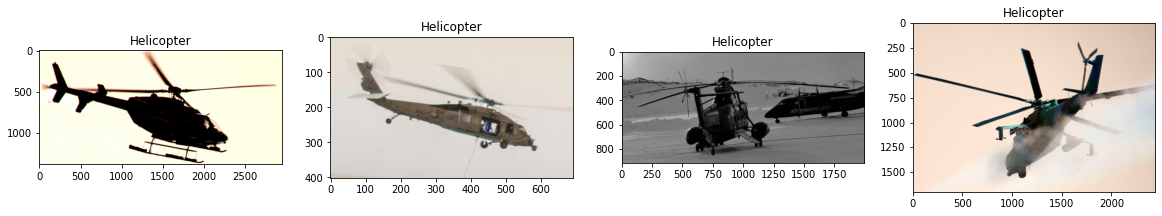

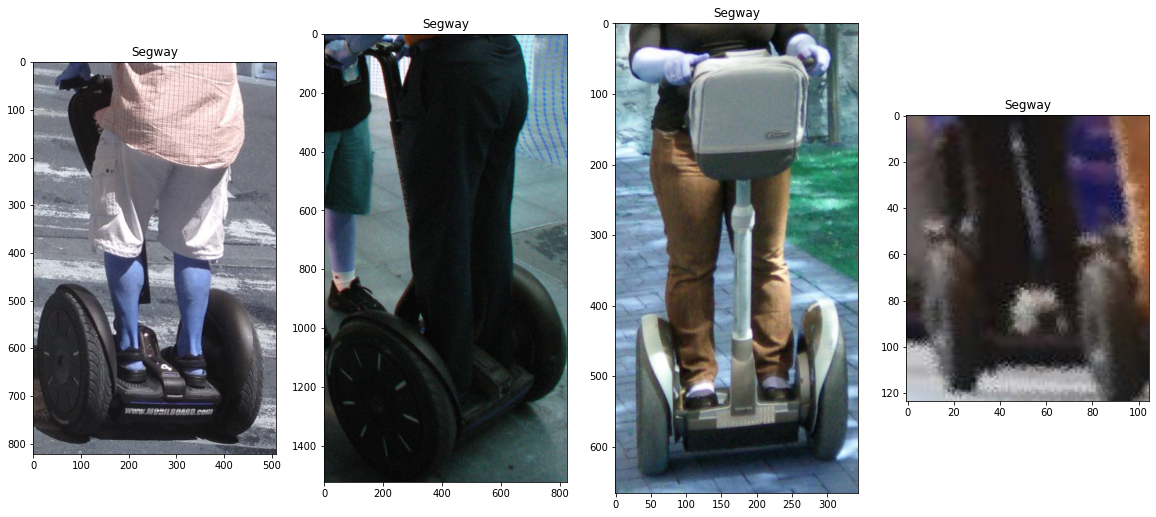

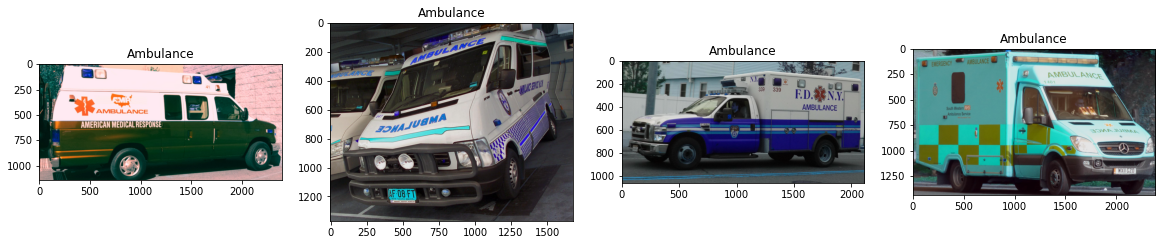

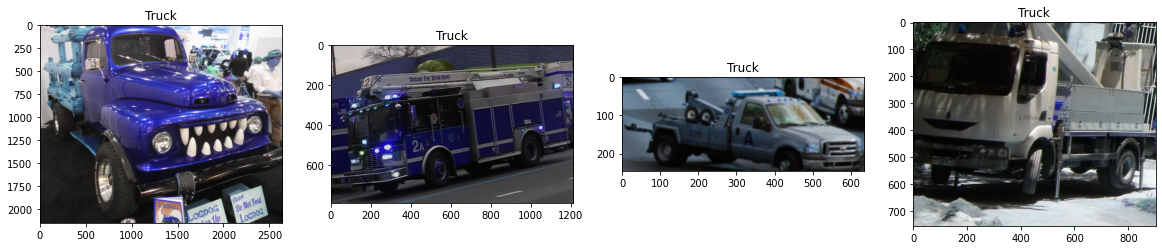

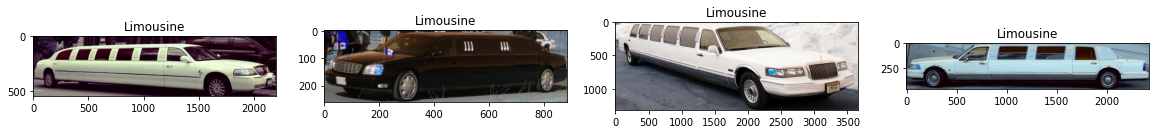

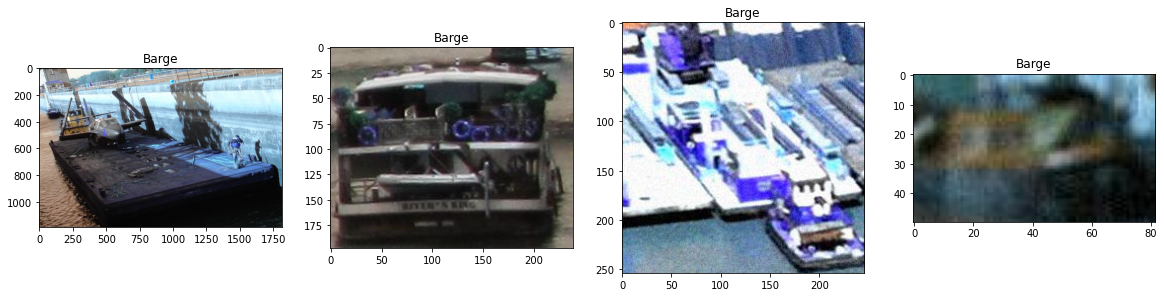

In [75]:
print("="*70)
print("Displaying 4 ranndom image per vehicle class")
print("="*70)

# for every class in 'cols'
for j in range(17):
    plt.figure(j)
    plt.figure(figsize=(20,20))
    
    # 4 images per every class
    for i in range(4):
        id = "14{}".format(i+1)
        plt.subplot(int(id))
        random_file = random.choice(os.listdir(BASE_PATH / cols[j]))
        img = cv2.imread(str(BASE_PATH / cols[j] / random_file)) # Shame on you cv2
        plt.title(cols[j])
        plt.imshow(img)
plt.show()

In [9]:
data = []
labels = []
cols = sorted(cols)

# Creating trainable 224x224 images
#                    -------
for vehicle_class in cols:
    print(vehicle_class + " started .....")
    for filename in df[vehicle_class]:
        try:
            # for empty cols
            if filename == None:
                pass
            else:   
                image = cv2.imread(str(BASE_PATH / vehicle_class / filename))
                image_from_numpy_array = Image.fromarray(image, "RGB")
                resized_image = image_from_numpy_array.resize((224, 224))
                data.append(np.array(resized_image))

                if vehicle_class == 'Ambulance':
                    labels.append(0)
                elif vehicle_class == 'Barge':
                    labels.append(1)
                elif vehicle_class == 'Bicycle':
                    labels.append(2)
                elif vehicle_class == 'Boat':
                    labels.append(3)
                elif vehicle_class == 'Bus':
                    labels.append(4)
                elif vehicle_class == 'Car':
                    labels.append(5)
                elif vehicle_class == 'Cart':
                    labels.append(6)
                elif vehicle_class == 'Caterpillar':
                    labels.append(7)
                elif vehicle_class == 'Helicopter':
                    labels.append(8)
                elif vehicle_class == 'Limousine':
                    labels.append(9)
                elif vehicle_class == 'Motorcycle':
                    labels.append(10)
                elif vehicle_class == 'Segway':
                    labels.append(11)
                elif vehicle_class == 'Snowmobile':
                    labels.append(12)
                elif vehicle_class == 'Tank':
                    labels.append(13)
                elif vehicle_class == 'Taxi':
                    labels.append(14)
                elif vehicle_class == 'Truck':
                    labels.append(15)
                elif vehicle_class == 'Van':
                    labels.append(16)
                else:
                    print("Something is wrong.")
                
        except AttributeError:
            print("Attribute error occured for " + filename)

Ambulance started .....
Barge started .....
Bicycle started .....
Boat started .....
Bus started .....
Car started .....
Cart started .....
Caterpillar started .....
Helicopter started .....
Limousine started .....
Motorcycle started .....
Segway started .....
Snowmobile started .....
Tank started .....
Taxi started .....
Truck started .....
Van started .....


In [10]:
vehicle_images_224x224 = np.array(data)
labels_224x224 = np.array(labels)

# save
np.save("all-vehicle-224x224-images-as-arrays", vehicle_images_224x224)
np.save("corresponding-labels-for-all-224x224-images", labels_224x224)

In [11]:
print(vehicle_images_224x224.shape)
print(labels_224x224.shape)
print(np.unique(labels_224x224))

(28045, 224, 224, 3)
(28045,)
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]


In [ ]:
# Move images to 'test' and 'train' dir
os.mkdir(INPUT_WORKING_PATH)
os.mkdir(INPUT_WORKING_PATH / 'test')
os.mkdir(INPUT_WORKING_PATH / 'train')

# Classes to be considered on the training of the model
classes = ['Bicycle', 'Boat', 'Bus', 'Car', 'Motorcycle', 'Truck', 'Van']

for dir in ["test", "train"]:
    for _class in classes:
        os.mkdir(INPUT_WORKING_PATH / dir / _class)

for _class in classes:
    images = os.listdir(BASE_PATH / _class)

    test = images[:300]
    
    # downsample to 1.5k images
    if len(images) < 1500:
      train = images[300:]
    else:
      train = images[300:1500]

    # move images to test-set folder
    for image in test:
        shutil.copy(BASE_PATH / _class / image, INPUT_WORKING_PATH / 'test' / _class / image)

    # move images to train-set folder
    for image in train:
        shutil.copy(BASE_PATH / _class / image, INPUT_WORKING_PATH / 'train' / _class / image)

# Image classification
It will return the category to which an image belongs. Specifically one array with the probabilities of the input image to belong to each of the categories in which the model was trained.

## Image pre-processing

In [15]:
train_datagen = ImageDataGenerator(
    shear_range=10,
    zoom_range=0.2,
    horizontal_flip=True,
    preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    INPUT_WORKING_PATH / 'train',
    batch_size=32,
    #class_mode='binary',
    target_size=(224,224))

validation_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input)

validation_generator = validation_datagen.flow_from_directory(
    INPUT_WORKING_PATH / 'test',
    shuffle=False,
    #class_mode='binary',
    target_size=(224,224))

Found 8011 images belonging to 7 classes.
Found 2100 images belonging to 7 classes.


## Transfer learning
Using an existing pre-trained model (called application in Keras). In this case is ResNet50, that has showed great results on image classfication problems.

In [17]:
conv_base = ResNet50(
    include_top=False,
    weights='imagenet')

for layer in conv_base.layers:
    layer.trainable = False

In [79]:
conv_base.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, None, None, 6 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [18]:
x = conv_base.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dense(512, activation='relu')(x)
predictions = layers.Dense(7, activation='softmax')(x)
model = Model(conv_base.input, predictions)

In [81]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, None, None, 6 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [19]:
optimizer = keras.optimizers.Adam()
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [20]:
history = model.fit_generator(generator=train_generator,
                              steps_per_epoch=347 // 32,  # added in Kaggle
                              epochs=30,
                              validation_data=validation_generator,
                              validation_steps=10  # added in Kaggle
                             )

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/30
10/10 [==============================] - 93s 9s/step - loss: 1.5472 - accuracy: 0.5469 - val_loss: 0.5438 - val_accuracy: 0.7750
Epoch 2/30
10/10 [==============================] - 88s 9s/step - loss: 0.6417 - accuracy: 0.7688 - val_loss: 0.7074 - val_accuracy: 0.7500
Epoch 3/30
10/10 [==============================] - 81s 8s/step - loss: 0.5635 - accuracy: 0.7906 - val_loss: 0.0918 - val_accuracy: 0.9625
Epoch 4/30
10/10 [==============================] - 81s 8s/step - loss: 0.5312 - accuracy: 0.7969 - val_loss: 0.7243 - val_accuracy: 0.7344
Epoch 5/30
10/10 [==============================] - 85s 8s/step - loss: 0.4751 - accuracy: 0.8313 - val_loss: 0.1881 - val_accuracy: 0.9281
Epoch 6/30
10/10 [==============================] - 92s 9s/step - loss: 0.5448 - accuracy: 0.8062 - val_loss: 0.2200 - val_accuracy: 0.9219
Epoch 7/30
10/10 [==============================] - 96s 10s/step - loss: 0.4704 - ac

## Saving the model and converting it into different formats

In [77]:
model.save(OUTPUT_MODELS_PATH / 'busModel.h5')
model.save_weights(OUTPUT_MODELS_PATH / 'busModelWeights.h5')

# Serialize model to json
model_json = model.to_json()
with open(OUTPUT_MODELS_PATH / 'busModel.json', 'w') as json_file:
    json_file.write(model_json)
    
    
# Convert keras model to tensorflow js model    
# HINT: Not used, at the end I used the command line utility to do this
# import tensorflowjs as tfjs
# tfjs.converters.save_keras_model(model, "C://Users//jaherran//Projects//Python//BusClassifier//vehicle//working//models2//")

## Evaluating the model

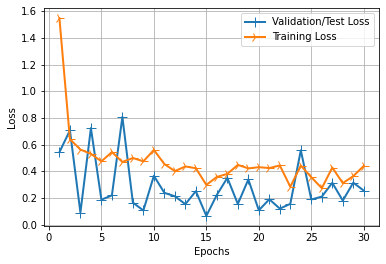

In [32]:
# plot loss chart

history_dict = history.history

loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)

line1 = plt.plot(epochs, val_loss_values, label='Validation/Test Loss')
line2 = plt.plot(epochs, loss_values, label='Training Loss')
plt.setp(line1, linewidth=2.0, marker = '+', markersize=10.0)
plt.setp(line2, linewidth=2.0, marker = '4', markersize=10.0)
plt.xlabel('Epochs') 
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

## Predicting using one validation input (No train, no test input)

In [76]:
# Loading the model from an existing file:
# model = load_model(OUTPUT_MODELS_PATH / 'busModel.h5')
# optimizer = keras.optimizers.Adam()
# model.compile(loss='categorical_crossentropy',
#               optimizer=optimizer,
#               metrics=['accuracy'])

input_file = INPUT_WORKING_PATH / 'validation' / '003.jpg'

def readb64(base64_string):
    nparr = np.frombuffer(base64.b64decode(base64_string), np.uint8)
    img = cv2.imdecode(nparr, cv2.IMREAD_COLOR)
    return img


# Load and encode the image to predict
with open(input_file, "rb") as img:
    encoded_string = base64.b64encode(img.read())
# print(encoded_string)
    
# img = cv2.imread(str(INPUT_WORKING_PATH / 'validation' / '003.jpg'))
img = readb64(encoded_string)
img = cv2.resize(img, (224,224))
img_np = np.reshape(img, [1, 224, 224, 3])
# print(img_np) 

cv2.imshow('First image', img)
cv2.waitKey(0)
cv2.destroyAllWindows()

pred = model.predict(img_np)


output_prediction = [ "{:.8f}".format(float(prediction*100)) for prediction in pred[0] ] 
print(output_prediction)

['0.19327305', '83.48262310', '15.54559022', '0.17784979', '0.34521944', '0.20249928', '0.05293632']


In [74]:
[{class_name: value} for class_name, value in zip(classes, output_prediction) ]

[{'Bicycle': '0.19327305'},
 {'Boat': '83.48262310'},
 {'Bus': '15.54559022'},
 {'Car': '0.17784979'},
 {'Motorcycle': '0.34521944'},
 {'Truck': '0.20249928'},
 {'Van': '0.05293632'}]

# Object detection
It will detect not just the category present in an image but the location of that object too.